# Introduction

Preparing for and running `pyscenic` at the command line.

# Setup

In [1]:
import scanpy as sc
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
import itertools as it
import json
import requests
import seaborn as sns
import pickle as pkl
from functools import reduce
import anndata
import matplotlib as mpl

In [2]:
sc.settings.verbosity = 4
sc.settings.set_figure_params(dpi=80)
sc.settings.n_jobs=16

In [3]:
mountpoint = '/data/clue/'
prefix_adts = mountpoint + 'prod/adts/'
prefix_mrna = mountpoint + 'prod/mrna/'
prefix_comb = mountpoint + 'prod/comb/'

In [4]:
with open(mountpoint + 'meta.pkl', 'rb') as file:
    ct_colors = pkl.load(file)['ct_colors']['ct2']['hex']
with open(mountpoint + 'meta.pkl', 'rb') as file:
    cond_colors = pkl.load(file)['cond_colors']['hex']

# Load in Data

SCENIC wants a gene and cell-filtered, unnormalized gene expression matrix as input.

In [17]:
path = prefix_comb + '/h5ads/concat_5.h5ad'
concat = sc.read_h5ad(path)
vars_keep = [i for i in concat.var_names if '|' not in i] # get the filtered vars and exclude the proteins

In [18]:
concat_raw = concat.raw.to_adata()

In [19]:
counts = concat_raw[((concat_raw.obs['ct2'] == 'cM') & (concat_raw.obs['cond'].isin(['B', 'G', 'C'])))][:, vars_keep].copy()

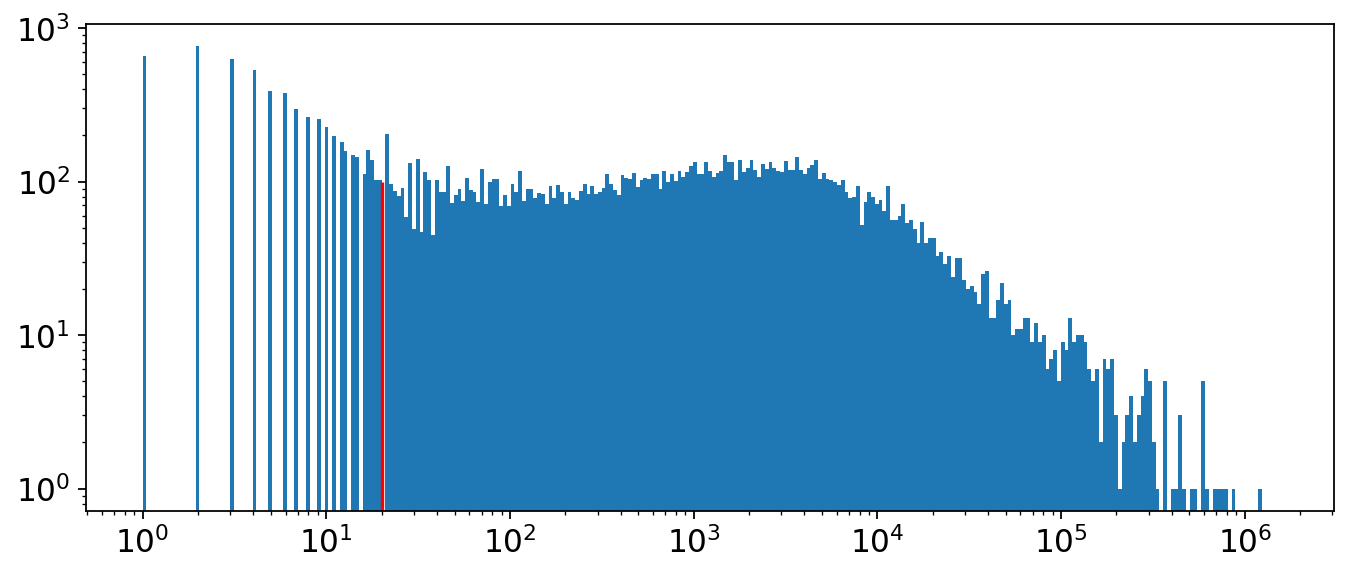

In [20]:
thresh = 20
plt.figure(figsize=(10, 4))
plt.hist(np.array(counts.X.sum(0))[0] + 1, bins=np.logspace(np.log10(1), np.log10(1.5e6), 300));
plt.vlines(thresh, 0, 100, color='red')
plt.grid()
plt.yscale('log')
plt.xscale('log')

In [21]:
(np.array(counts.X.sum(0))[0] >= thresh).sum()

14764

In [22]:
counts = counts[:, (np.array(counts.X.sum(0))[0] >= thresh)].copy()

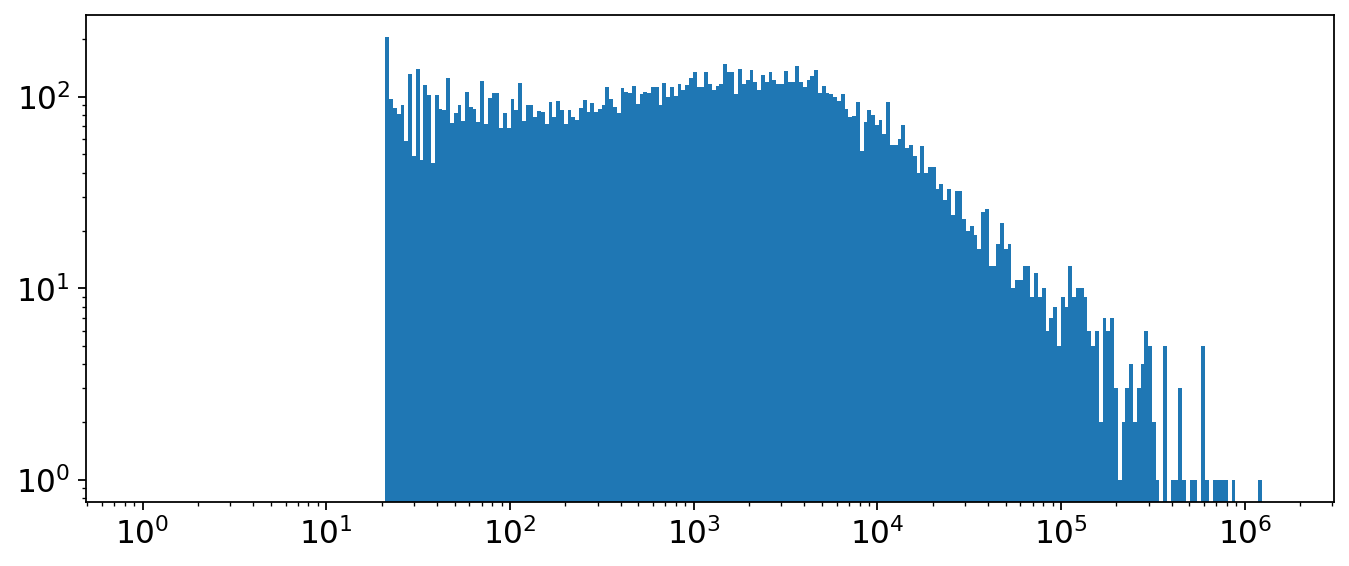

In [23]:
plt.figure(figsize=(10, 4))
plt.hist(np.array(counts.X.sum(0))[0] + 1, bins=np.logspace(np.log10(1), np.log10(1.5e6), 300));
plt.grid()
plt.yscale('log')
plt.xscale('log')

Read in the curated transcription factors, downloaded from [pyscenic's GitHub page](https://github.com/aertslab/pySCENIC/blob/master/resources/hs_hgnc_curated_tfs.txt):

In [24]:
tfs = pd.read_csv(prefix_mrna + 'scenic/hs_hgnc_curated_tfs.txt', header=None).values.flatten()

In [25]:
np.intersect1d(tfs, counts.var_names).shape

(903,)

In [26]:
counts.shape

(10508, 14764)

In [30]:
counts.write_h5ad(prefix_mrna + 'scenic/raw_counts.h5ad')
counts.to_df().to_csv(prefix_mrna + 'scenic/raw_counts.csv')

# Run GRNBoost

Using `pyscenic` version `0.11.2`, ran the following at the command line:

```
pyscenic grn raw_counts.csv ../hs_hgnc_curated_tfs.txt -o adj.csv --num_workers 14 --seed 0
```
<br />

This outputs the adjacency matrix `adj.csv` which is fed into `cisTarget`.

## Run cisTarget

Cool. Now have to run the second command. It requires some extra files which I got from the [aertslab website](https://resources.aertslab.org/cistarget/). These are the following:
```
hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.feather
motifs-v9-nr.hgnc-m0.001-o0.0.tbl
```
Now, the second command is:
```
pyscenic ctx adj.csv hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.feather --annotations_fname motifs-v9-nr.hgnc-m0.001-o0.0.tbl --expression_mtx_fname raw_counts.csv --output reg.csv --mask_dropouts --num_workers 14
```

# Confirm High Gene Counts

In the tutorial, it says it's important to confirm we have high gene counts per cell.

In [5]:
reg = pd.read_csv(prefix_mrna + 'scenic/reg.csv', header=[0, 1], index_col=[0, 1])

In [27]:
# nGenesDetectedPerCell = np.sum(counts.X>0, axis=1)
sc.pp.filter_cells(counts, min_genes=0)
nGenesDetectedPerCell = counts.obs['n_genes'].copy()
percentiles = nGenesDetectedPerCell.quantile([.01, .05, .10, .50, 1])
print(percentiles)

0.01    1561.21
0.05    1877.00
0.10    2059.00
0.50    2698.00
1.00    7072.00
Name: n_genes, dtype: float64


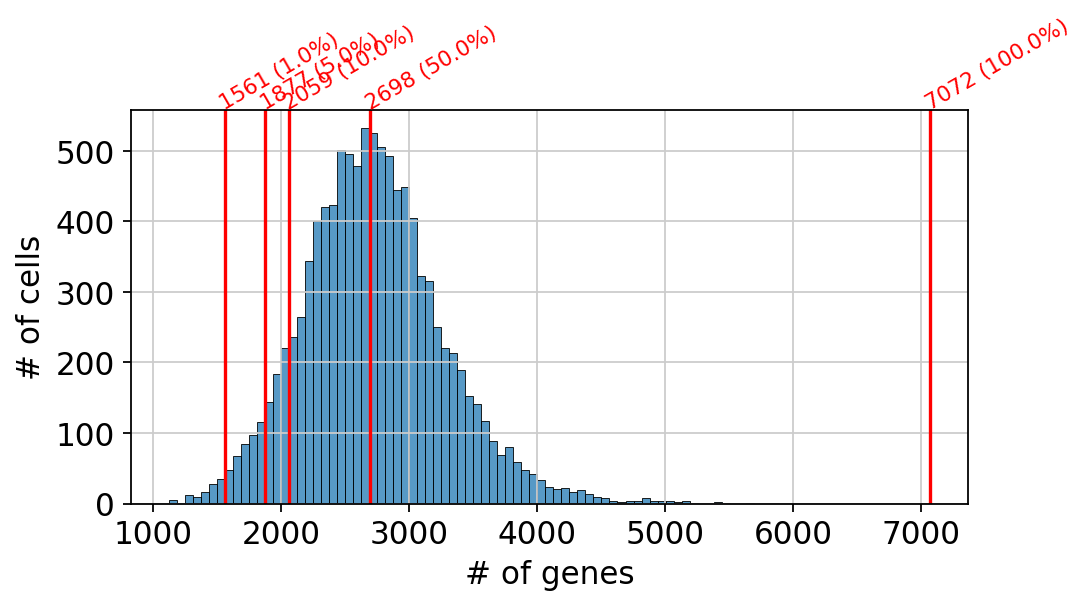

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4), dpi=80)
sns.histplot(nGenesDetectedPerCell, bins='fd', ax=ax)# norm_hist=False, kde=False, bins='fd')
for i,x in enumerate(percentiles):
    fig.gca().axvline(x=x, ymin=0,ymax=1, color='red')
    ax.text(x=x, y=ax.get_ylim()[1], s=f'{int(x)} ({percentiles.index.values[i]*100}%)', color='red', rotation=30, size='x-small',rotation_mode='anchor' )
ax.set_xlabel('# of genes')
ax.set_ylabel('# of cells')
fig.tight_layout()

Looks like we're good.

## Run AUCell

```
pyscenic aucell raw_counts.csv reg.csv --output aucell_output.csv --num_workers 14
```
<br />

Cool, that took like 1 minute to run. Will be analyzing the results in the `ifn.ipynb` notebook.